<a href="https://colab.research.google.com/github/Andreavisi1/Challenge_B1_PHM_North_America_2023/blob/main/challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


ModuleNotFoundError: No module named 'google'

In [ ]:
!cp "/content/drive/MyDrive/ProgettoManutenzionePreventiva/Data_Challenge_PHM2023_test_data.zip" "/tmp/"

!unzip -oq "/tmp/Data_Challenge_PHM2023_test_data.zip" -d "/tmp"

!cp "/content/drive/MyDrive/ProgettoManutenzionePreventiva/Data_Challenge_PHM2023_training_data.zip" "/tmp/"

!unzip -oq "/tmp/Data_Challenge_PHM2023_training_data.zip" -d "/tmp"

In [2]:
# Converts relative paths to absolute ones
ROOT_TRAIN_DATA_FOLDER ='../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data'
ROOT_VAL_DATA_FOLDER = '../B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_test_data'

In [4]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Data Extraction

In [3]:
def parse_vibration_dataset(dataset_path, compute_stats=True):
    """
    Parsa il dataset di vibrazione e crea un DataFrame con statistiche aggregate per file.
    
    Args:
        dataset_path (str): Percorso alla cartella principale del dataset
        compute_stats (bool): Se True, calcola statistiche invece di caricare tutti i dati
    
    Returns:
        pd.DataFrame: DataFrame con statistiche per ogni file
    """
    
    data_list = []
    
    # Conta prima i file per la progress bar
    total_files = sum(1 for root, dirs, files in os.walk(dataset_path) 
                     for file in files if file.endswith('.txt'))
    
    print(f"Trovati {total_files} file da processare...")
    
    with tqdm(total=total_files, desc="Processing files") as pbar:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.txt'):
                    pbar.update(1)
                    
                    # Estrai informazioni dalla cartella
                    folder_name = os.path.basename(root)
                    if 'Pitting_degradation_level_' in folder_name:
                        etichetta = folder_name.replace('Pitting_degradation_level_', '').strip()
                        # Gestisci eventuali descrizioni tra parentesi
                        if '(' in etichetta:
                            etichetta = etichetta.split('(')[0].strip()
                    else:
                        etichetta = folder_name
                    
                    # Estrai informazioni dal nome del file
                    pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                    match = re.search(pattern, file)
                    
                    if match:
                        velocita = int(match.group(1))
                        torque = int(match.group(2))
                        rep = int(match.group(3))
                        
                        file_path = os.path.join(root, file)
                        
                        try:
                            # Carica i dati
                            data = np.loadtxt(file_path)
                            
                            if compute_stats:
                                # Calcola statistiche invece di salvare tutti i dati
                                record = {
                                    'etichetta': etichetta,
                                    'velocita': velocita,
                                    'torque': torque,
                                    'rep': rep,
                                    'file_path': file_path,
                                    'num_samples': len(data),
                                    # Statistiche accelerazione orizzontale
                                    'h_acc_mean': np.mean(data[:, 0]),
                                    'h_acc_std': np.std(data[:, 0]),
                                    'h_acc_rms': np.sqrt(np.mean(data[:, 0] ** 2)),
                                    'h_acc_max': np.max(np.abs(data[:, 0])),
                                    'h_acc_kurtosis': np.mean((data[:, 0] - np.mean(data[:, 0]))**4) / np.std(data[:, 0])**4 - 3,
                                    'h_acc_skewness': np.mean((data[:, 0] - np.mean(data[:, 0]))**3) / np.std(data[:, 0])**3,
                                    # Statistiche accelerazione assiale
                                    'a_acc_mean': np.mean(data[:, 1]),
                                    'a_acc_std': np.std(data[:, 1]),
                                    'a_acc_rms': np.sqrt(np.mean(data[:, 1] ** 2)),
                                    'a_acc_max': np.max(np.abs(data[:, 1])),
                                    'a_acc_kurtosis': np.mean((data[:, 1] - np.mean(data[:, 1]))**4) / np.std(data[:, 1])**4 - 3,
                                    'a_acc_skewness': np.mean((data[:, 1] - np.mean(data[:, 1]))**3) / np.std(data[:, 1])**3,
                                    # Statistiche accelerazione verticale
                                    'v_acc_mean': np.mean(data[:, 2]),
                                    'v_acc_std': np.std(data[:, 2]),
                                    'v_acc_rms': np.sqrt(np.mean(data[:, 2] ** 2)),
                                    'v_acc_max': np.max(np.abs(data[:, 2])),
                                    'v_acc_kurtosis': np.mean((data[:, 2] - np.mean(data[:, 2]))**4) / np.std(data[:, 2])**4 - 3,
                                    'v_acc_skewness': np.mean((data[:, 2] - np.mean(data[:, 2]))**3) / np.std(data[:, 2])**3,
                                    # Tachometer info
                                    'tach_mean': np.mean(data[:, 3]) if data.shape[1] > 3 else 0,
                                    'tach_std': np.std(data[:, 3]) if data.shape[1] > 3 else 0
                                }
                                data_list.append(record)
                            else:
                                # Salva solo metadati base
                                record = {
                                    'etichetta': etichetta,
                                    'velocita': velocita,
                                    'torque': torque,
                                    'rep': rep,
                                    'file_path': file_path,
                                    'num_samples': len(data),
                                    'data': data  # Attenzione: usa solo per pochi file!
                                }
                                data_list.append(record)
                                
                        except Exception as e:
                            print(f"\nErrore nel leggere il file {file_path}: {e}")
                            continue
                    else:
                        print(f"\nNome file non riconosciuto: {file}")
    
    df = pd.DataFrame(data_list)
    
    if not df.empty:
        # Converti etichetta in intero se possibile
        try:
            df['etichetta'] = df['etichetta'].astype(int)
        except:
            print("Etichette non convertibili in interi")
            
        df = df.sort_values(['etichetta', 'velocita', 'torque', 'rep']).reset_index(drop=True)
    
    return df

def extract_frequency_features(data, fs=20480, n_features=20):
    """
    Estrae features nel dominio della frequenza.
    
    Args:
        data: array di dati temporali
        fs: frequenza di campionamento
        n_features: numero di features da estrarre
    
    Returns:
        dict: dizionario con le features estratte
    """
    # FFT
    fft = np.fft.rfft(data)
    freq = np.fft.rfftfreq(len(data), 1/fs)
    magnitude = np.abs(fft)
    
    # Trova picchi principali
    from scipy.signal import find_peaks
    peaks, properties = find_peaks(magnitude, height=np.max(magnitude)*0.1)
    
    features = {}
    
    # Frequenze dei picchi principali
    top_peaks = peaks[np.argsort(magnitude[peaks])[-n_features:]]
    for i, peak_idx in enumerate(top_peaks[:5]):  # Top 5 frequenze
        features[f'peak_freq_{i}'] = freq[peak_idx]
        features[f'peak_mag_{i}'] = magnitude[peak_idx]
    
    # Statistiche spettrali
    features['spectral_centroid'] = np.sum(freq * magnitude) / np.sum(magnitude)
    features['spectral_spread'] = np.sqrt(np.sum(((freq - features['spectral_centroid'])**2) * magnitude) / np.sum(magnitude))
    features['spectral_energy'] = np.sum(magnitude**2)
    
    return features

def load_single_file_data(file_path):
    """
    Carica i dati di un singolo file.
    
    Args:
        file_path: percorso del file
    
    Returns:
        np.array: dati del file
    """
    return np.loadtxt(file_path)

# Esempio di utilizzo con batching per evitare problemi di memoria
def process_dataset_in_batches(dataset_path, batch_size=100):
    """
    Processa il dataset in batch per evitare problemi di memoria.
    """
    # Prima ottieni solo i metadati
    print("Caricamento metadati...")
    df_meta = parse_vibration_dataset(dataset_path, compute_stats=True)
    
    print(f"\nDataset caricato con successo!")
    print(f"Numero di file processati: {len(df_meta)}")
    print(f"Etichette uniche: {sorted(df_meta['etichetta'].unique())}")
    print(f"Velocità uniche: {sorted(df_meta['velocita'].unique())}")
    print(f"Torque unici: {sorted(df_meta['torque'].unique())}")
    
    return df_meta

"""
def get_vibration_statistics(df):

    Calcola statistiche sui dati di vibrazione, raggruppando per file.

    Args:
        df (pd.DataFrame): DataFrame con una riga per ogni misura

    Returns:
        pd.DataFrame: DataFrame con statistiche per ogni combinazione (etichetta, velocità, torque, rep)


    stats_list = []

    grouped = df.groupby(['etichetta', 'descrizione', 'velocita', 'torque', 'rep'])

    for (etichetta, descrizione, velocita, torque, rep), group in grouped:
        h_acc = group['horizontal_acceleration'].values
        a_acc = group['axial_acceleration'].values
        v_acc = group['vertical_acceleration'].values

        stats = {
            'etichetta': etichetta,
            'descrizione': descrizione,
            'velocita': velocita,
            'torque': torque,
            'rep': rep,
            # Statistiche accelerazione orizzontale
            'h_acc_mean': np.mean(h_acc),
            'h_acc_std': np.std(h_acc),
            'h_acc_rms': np.sqrt(np.mean(h_acc ** 2)),
            'h_acc_max': np.max(np.abs(h_acc)),
            # Statistiche accelerazione assiale
            'a_acc_mean': np.mean(a_acc),
            'a_acc_std': np.std(a_acc),
            'a_acc_rms': np.sqrt(np.mean(a_acc ** 2)),
            'a_acc_max': np.max(np.abs(a_acc)),
            # Statistiche accelerazione verticale
            'v_acc_mean': np.mean(v_acc),
            'v_acc_std': np.std(v_acc),
            'v_acc_rms': np.sqrt(np.mean(v_acc ** 2)),
            'v_acc_max': np.max(np.abs(v_acc)),
            # Info generali
            'num_samples': len(group)
        }

        stats_list.append(stats)

    return pd.DataFrame(stats_list)
"""

"\ndef get_vibration_statistics(df):\n\n    Calcola statistiche sui dati di vibrazione, raggruppando per file.\n\n    Args:\n        df (pd.DataFrame): DataFrame con una riga per ogni misura\n\n    Returns:\n        pd.DataFrame: DataFrame con statistiche per ogni combinazione (etichetta, velocità, torque, rep)\n\n\n    stats_list = []\n\n    grouped = df.groupby(['etichetta', 'descrizione', 'velocita', 'torque', 'rep'])\n\n    for (etichetta, descrizione, velocita, torque, rep), group in grouped:\n        h_acc = group['horizontal_acceleration'].values\n        a_acc = group['axial_acceleration'].values\n        v_acc = group['vertical_acceleration'].values\n\n        stats = {\n            'etichetta': etichetta,\n            'descrizione': descrizione,\n            'velocita': velocita,\n            'torque': torque,\n            'rep': rep,\n            # Statistiche accelerazione orizzontale\n            'h_acc_mean': np.mean(h_acc),\n            'h_acc_std': np.std(h_acc),\n     

In [5]:
# 1. Carica solo le statistiche (non tutti i dati raw)
df_stats = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER, compute_stats=True)

Trovati 2016 file da processare...


Processing files: 100%|██████████| 2016/2016 [01:46<00:00, 18.84it/s]


In [7]:
df_stats.head()

,etichetta,velocita,torque,rep,file_path,num_samples,h_acc_mean,h_acc_std,h_acc_rms,h_acc_max,...,a_acc_kurtosis,a_acc_skewness,v_acc_mean,v_acc_std,v_acc_rms,v_acc_max,v_acc_kurtosis,v_acc_skewness,tach_mean,tach_std
0,0,100,50,1,../B - PHM America 2023 - Dataset/Data_Challen...,246784,-0.042038,0.125520,0.132372,0.794698,...,4.027344,-1.769514,-0.044633,0.160855,0.166933,0.960053,1.653813,-1.064047,0.000045,0.006676
1,0,100,50,2,../B - PHM America 2023 - Dataset/Data_Challen...,246784,0.000117,0.073937,0.073937,0.315845,...,-0.863800,-0.284632,0.000373,0.121048,0.121048,0.480931,-0.931058,-0.285521,0.000045,0.006676
2,0,100,50,3,../B - PHM America 2023 - Dataset/Data_Challen...,246784,-0.000060,0.074461,0.074461,0.336066,...,-0.873805,-0.284445,0.000120,0.121833,0.121833,0.610111,-0.925968,-0.286603,0.000045,0.006676
3,0,100,50,4,../B - PHM America 2023 - Dataset/Data_Challen...,246784,-0.000147,0.075356,0.075357,0.312247,...,-0.878043,-0.284044,0.000238,0.123235,0.123235,0.502260,-0.932720,-0.286181,0.000045,0.006676
4,0,100,50,5,../B - PHM America 2023 - Dataset/Data_Challen...,246784,0.000048,0.076296,0.076296,0.369684,...,-0.867587,-0.287599,-0.000050,0.124723,0.124723,0.637706,-0.925662,-0.287988,0.000045,0.006676


In [8]:
# 2. Salva le statistiche per uso futuro
df_stats.to_pickle("vibration_stats.pkl")
df_stats.to_csv("vibration_stats.csv", index=False)

In [9]:
# 3. Analisi esplorativa
print("Shape del dataset:", df_stats.shape)
print("\nPrime righe:")
print(df_stats.head())

Shape del dataset: (2016, 26)

Prime righe:
   etichetta  velocita  torque  rep  \
0          0       100      50    1   
1          0       100      50    2   
2          0       100      50    3   
3          0       100      50    4   
4          0       100      50    5   

                                           file_path  num_samples  h_acc_mean  \
0  ../B - PHM America 2023 - Dataset/Data_Challen...       246784   -0.042038   
1  ../B - PHM America 2023 - Dataset/Data_Challen...       246784    0.000117   
2  ../B - PHM America 2023 - Dataset/Data_Challen...       246784   -0.000060   
3  ../B - PHM America 2023 - Dataset/Data_Challen...       246784   -0.000147   
4  ../B - PHM America 2023 - Dataset/Data_Challen...       246784    0.000048   

   h_acc_std  h_acc_rms  h_acc_max  ...  a_acc_kurtosis  a_acc_skewness  \
0   0.125520   0.132372   0.794698  ...        4.027344       -1.769514   
1   0.073937   0.073937   0.315845  ...       -0.863800       -0.284632   
2   0.074

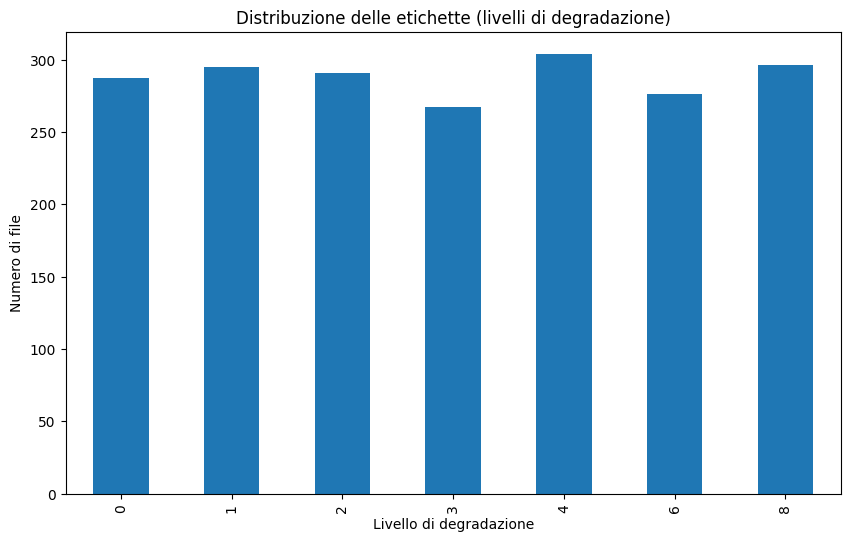

In [10]:
# 4. Distribuzione delle etichette
plt.figure(figsize=(10, 6))
df_stats['etichetta'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuzione delle etichette (livelli di degradazione)')
plt.xlabel('Livello di degradazione')
plt.ylabel('Numero di file')
plt.show()

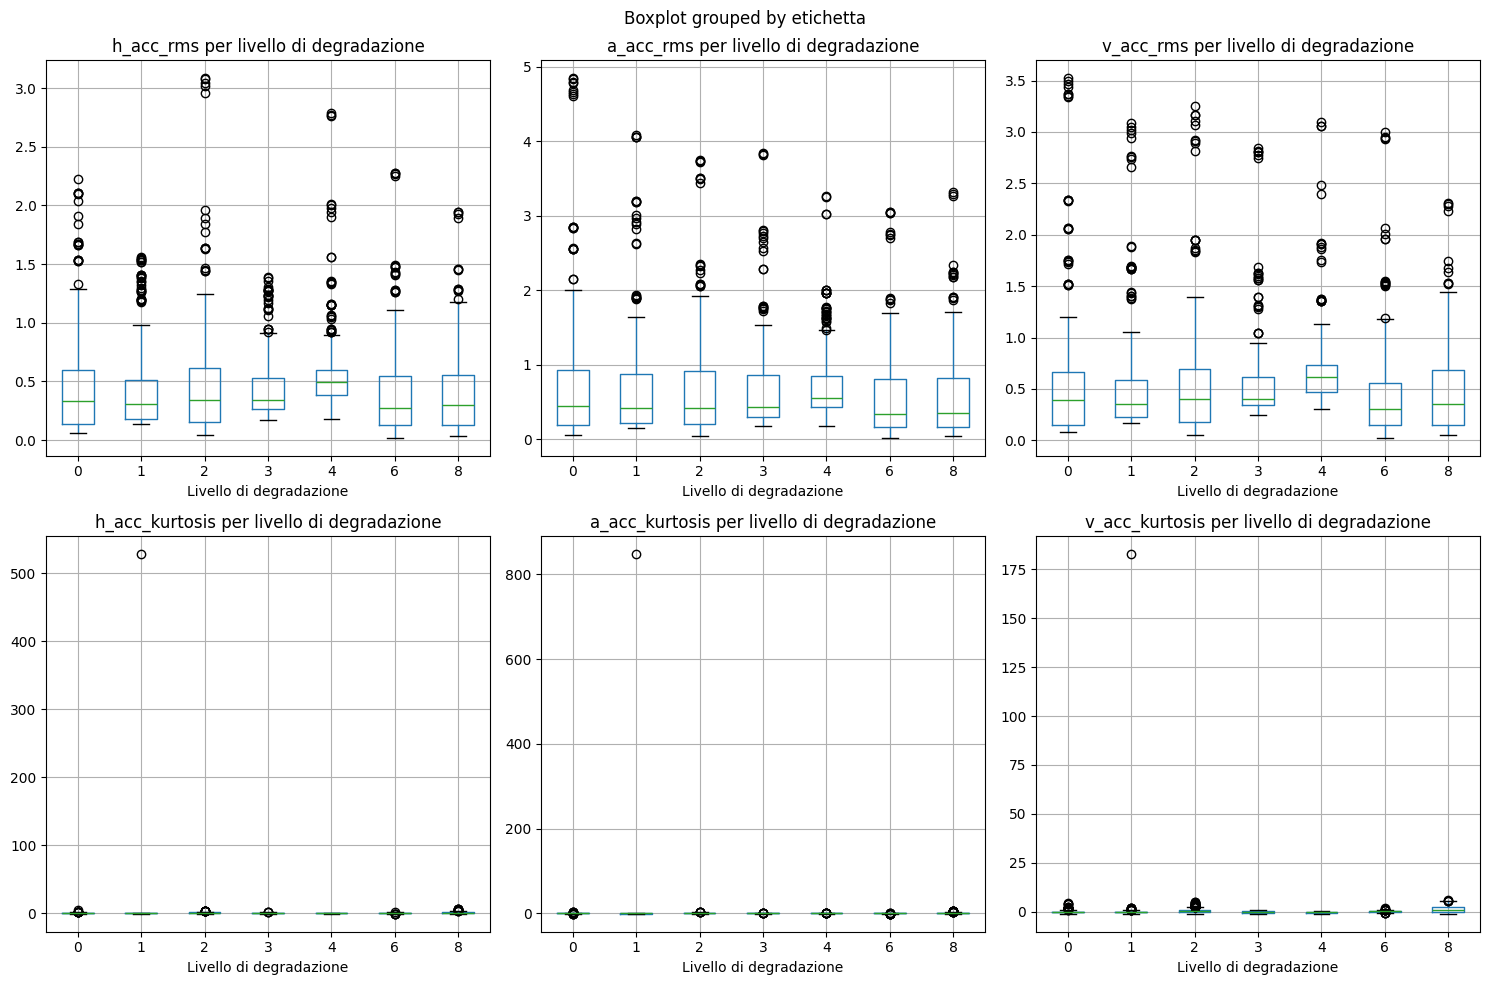

In [11]:
# 5. Analisi delle features per livello di degradazione
features_to_analyze = ['h_acc_rms', 'a_acc_rms', 'v_acc_rms', 
                      'h_acc_kurtosis', 'a_acc_kurtosis', 'v_acc_kurtosis']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_analyze):
    df_stats.boxplot(column=feature, by='etichetta', ax=axes[i])
    axes[i].set_title(f'{feature} per livello di degradazione')
    axes[i].set_xlabel('Livello di degradazione')

plt.tight_layout()
plt.show()

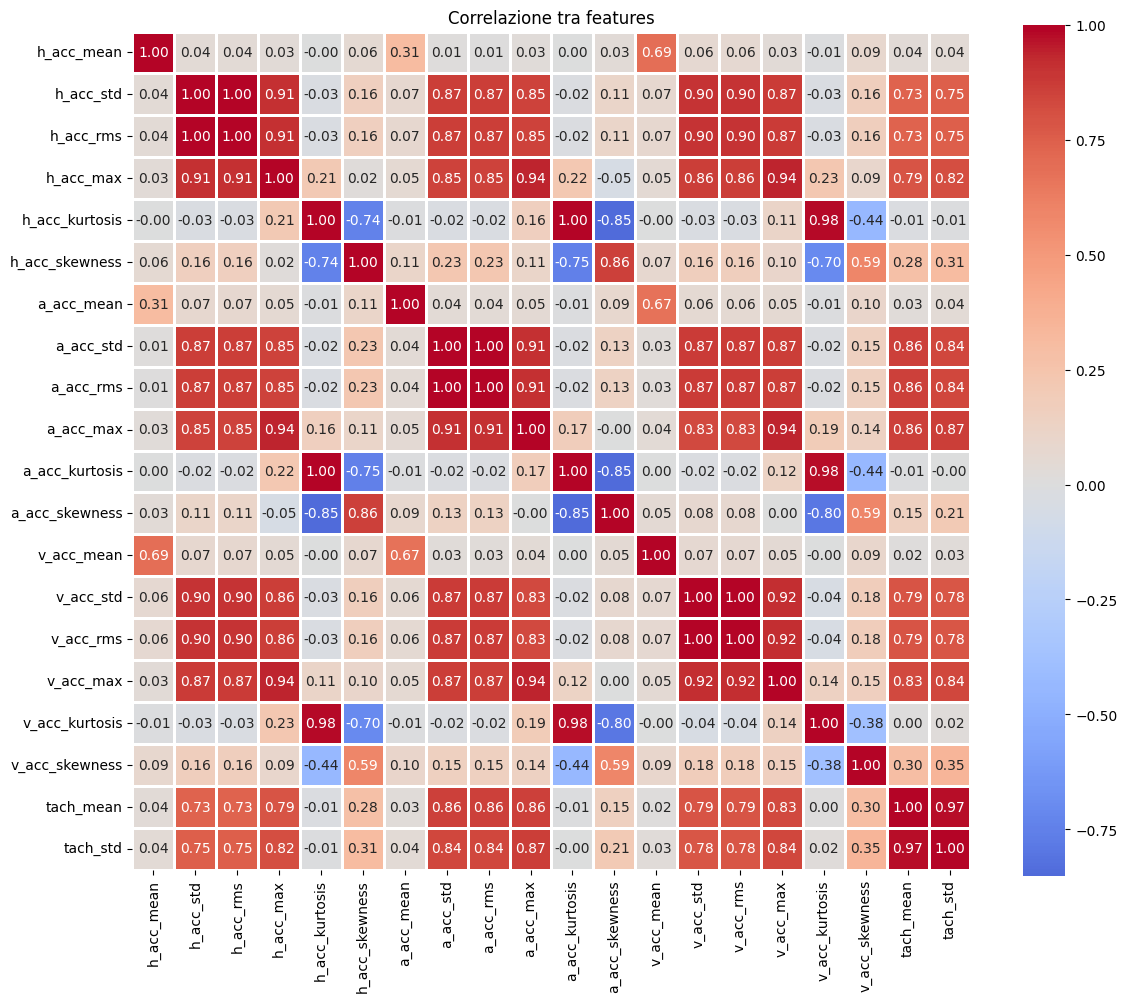

In [13]:
# 6. Correlazione tra features (escludendo metadati)
feature_cols = [col for col in df_stats.columns 
                if col not in ['etichetta', 'velocita', 'torque', 'rep', 
                              'file_path', 'num_samples']]

plt.figure(figsize=(12, 10))
correlation_matrix = df_stats[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlazione tra features')
plt.tight_layout()
plt.show()

## Normalization

In [15]:
def preprocess_signal(signal, fs=20480):
    signal = signal - np.mean(signal)
    from scipy.signal import butter, filtfilt
    low_freq = 10  # Hz
    high_freq = fs/2 * 0.9
    b, a = butter(4, [low_freq, high_freq], btype='band', fs=fs)
    signal_filtered = filtfilt(b, a, signal)
    return signal_filtered

def preprocess_dataframe(df, fs=20480):
    for col in ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration']:
        print(f"Preprocessing {col}...")
        df[col] = df[col].apply(lambda x: preprocess_signal(x, fs=fs))
    return df

## Correlation

In [17]:
# Creazione della heatmap
plt.figure(figsize=(20, 15))
ax = sns.heatmap(df_stats.drop(['weight_status'], axis=1).corr(), cmap="Blues", annot=True, fmt=".2f", annot_kws={"size": 14})

# Aumenta la dimensione dei label degli assi
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=45, ha='right')  # Rotazione per leggibilità
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

plt.show()

KeyError: "['weight_status'] not found in axis"

<Figure size 2000x1500 with 0 Axes>